In [ ]:
# default_exp h5dataset

# H5Dataset

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

import numpy as np
import h5py
import tensorflow as tf

import mmwave

import logging

logger = logging.getLogger()

In [ ]:
#export

class H5DatasetIterator():
    """Iterates through aligned frames dataset"""
    def __init__(self, dset, streams):
        super().__init__()
        self._dset = dset
        self._idx = 0
        self.req_streams = streams

    def __iter__(self):
        return self

    def __next__(self):
        self._idx += 1
        try:
            return tuple(self._dset[s][self._idx] for s in self.req_streams)
        except ValueError:
            self._idx = 0
            raise StopIteration

    def __len__(self):
        return len(self._dset)

class H5DatasetLoader(object):
    """A thin wrapper around h5py to provide convenience functions for training"""
    def __init__(self, filenames, default_streams=None):
        super(H5DatasetLoader, self).__init__()
        self.filenames = filenames
        if isinstance(self.filenames, list):
            raise NotImplementedError
        else:
            self.h5_file = h5py.File(self.filenames, 'r')
        self.streams_available = list(self.h5_file.keys())
        self.default_streams = default_streams

        if default_streams is not None:
            for s in default_streams:
                assert s in self.streams_available, f"{s} not found in available streams"

    def __len__(self):
        return len(self.h5_file[self.streams_available[0]])

    def __getitem__(self, stream):
        return self.h5_file[stream]

    def get_iterator(self, streams=None):
        """The default iterator includes all available streams in the order available on the h5 file"""
        if not streams:
            streams = self.default_streams.copy() if self.default_streams is not None else self.streams_available.copy()
        return H5DatasetIterator(self, streams)

    def __iter__(self):
        return self.get_iterator()

    @property
    def filename(self):
        return self.filenames

    def get_tf_dataset(self,
                       streams=['radar', 'rgb', 'depth'],
                       shuffle=False,
                       repeat=False,
                       batchsize=16,
                       preprocess_chain=None,
                       prefetch=2,
                       flatten_single=False,
                      ):
        logger.debug("Tensorflow Dataset creation")

        out_shapes = tuple([
            tf.TensorShape(list(self.h5_file[s].shape[1:])) for s in streams
        ])
        out_types = tuple([self.h5_file[s].dtype for s in streams])

        def _gen():
            for i in range(len(self.h5_file[streams[0]])):
                yield tuple(self.h5_file[s][i] for s in streams)

        _dataset = tf.data.Dataset.from_generator(
            _gen,
            output_types = out_types,
            output_shapes = out_shapes,
        )

        if shuffle:
            debug("  Outputs of dataset will be shuffled")
            _dataset = _dataset.shuffle(batchsize * 4)

        if repeat:
            debug(f'  Dataset will be repeated {repeat} files')
            _dataset = _dataset.repeat(repeat)

        if preprocess_chain is not None:
            for op in preprocess_chain:
                _dataset = _dataset.map(op)

        if flatten_single:
            assert(len(streams) == 1)
            logger.debug("  Flattening shapes for single stream inference")
            logger.debug(_dataset)
            _dataset = _dataset.map(lambda x: x)
            logger.debug(_dataset)

        _dataset = _dataset.batch(batchsize)


        if prefetch:
            _dataset = _dataset.prefetch(prefetch)

        return _dataset

`indoor_sample.h5` was generated from csl_lobby/2020-03-05-16-35-19.bag.export.h5, sliced `[0:200*30:30]`

In [ ]:
#hide
#skip

import matplotlib.pyplot as plt
from fastprogress import progress_bar

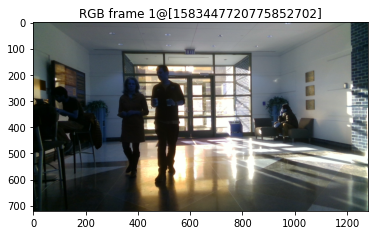

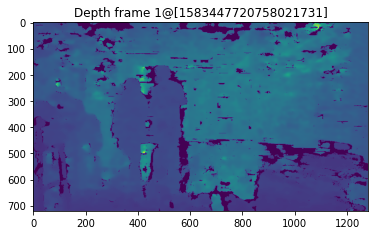

In [ ]:
#skip

data = H5DatasetLoader('../samples/indoor_sample.h5')

frame_idx = 1
plt.figure()
plt.imshow(data['rgb'][frame_idx])
plt.title(f'RGB frame {frame_idx}@{data["rgb_timestamp"][frame_idx]}')
plt.show()
plt.figure()
plt.imshow(data['depth'][frame_idx])
plt.title(f'Depth frame {frame_idx}@{data["depth_timestamp"][frame_idx]}')
plt.show()

Also available as iterator

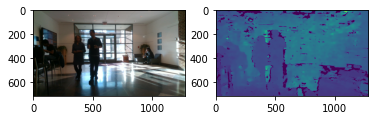

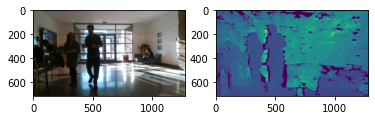

In [ ]:
#skip
count = 0

for radar_frame, rgb_frame, depth_frame in progress_bar(data.get_iterator(['radar', 'rgb', 'depth'])):
    plt.figure()
    plt.subplot(121)
    plt.imshow(rgb_frame[:, :, ::-1])
    plt.subplot(122)
    plt.imshow(depth_frame)
    plt.show()
    
    # Stop after 2 frames so we don't spam the docs
    count += 1
    if count > 1:
        break

Default streams can also be set so `get_iterator()` isn't required

In [ ]:
#skip
data = H5DatasetLoader('../samples/indoor_sample.h5', default_streams=['radar', 'rgb', 'depth'])

for radar_frame, rgb_frame, depth_frame in progress_bar(data):
    np.mean(rgb_frame)